In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms as T
from torch.utils.data import SubsetRandomSampler as SRS
from torch.utils.data import DataLoader
from data.Dataset import Proteins
from sklearn.model_selection import train_test_split
from config import DefaultConfig
from models import resnet101
import time
import os

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
opt =DefaultConfig()

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])
])

dataset_AB42_SYN = Proteins(root=opt.root,transforms=transform)

# Split train and test sets 7:3
train_idx, val_test_idx = train_test_split(
    np.arange(len(dataset_AB42_SYN.labels)),
    test_size=0.3,
    stratify=dataset_AB42_SYN.labels
)

val_test_labels = [dataset_AB42_SYN.labels[i] for i in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.66, stratify=val_test_labels)

train_sampler = SRS(train_idx)
val_sampler = SRS(val_idx)
test_sampler = SRS(test_idx)

train_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=train_sampler)
val_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=val_sampler)
test_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=test_sampler)

In [300]:
len(val_loader)

4

In [301]:
dataset_AB42_SYN.labels.count(0),dataset_AB42_SYN.labels.count(1)

(184, 176)

In [4]:
# Setup for Visdom
import visdom
vis = visdom.Visdom(env=u'protein')
vis.line([0],[0], win='train_acc', opts=dict(title='train acc', legend=['train acc']))
vis.line([0],[0], win='val_acc', opts=dict(title='val acc', legend=['val acc']))
#vis.line([0],[0], win='test', opts=dict(title='test loss & acc', legend=['loss', 'acc']))

Setting up a new session...


'val_acc'

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, train_loader=train_loader, val_loader=val_loader):
    since = time.time()
    global_step = 0

    for epoch in range(num_epochs):
        print('Epoch {}{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                        
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)  # 1 is the dimension
                loss = criterion(outputs, labels)

                # backward + optimize
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Decay learning rate

        epoch_loss = running_loss / train_loader.sampler.indices.shape[0]
        epoch_acc = running_corrects.item() / train_loader.sampler.indices.shape[0]

        print('{} Loss: {: .4f} Acc: {: .4f}'.format(
            'Train', epoch_loss, epoch_acc
        ))
        
        # plot for visdom
        global_step += 1
        vis.line([epoch_acc],[global_step], win='train', update='append')
        scheduler.step()
        
        # start validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            loss = criterion(outputs,labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
        
        epoch_val_loss = val_loss/val_loader.sampler.indices.shape[0]
        epoch_val_acc = val_corrects.item()/val_loader.sampler.indices.shape[0]
        
        # visdom plot
        vis.line([epoch_val_acc], [global_step],win='val', update='append')
            
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))

    # load best model weights
    return model

In [6]:
def test(model, test_loader=test_loader):
    test_corrects = 0
    
    model.eval()
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _,preds = torch.max(outputs,1)
        
        test_corrects += torch.sum(preds == labels.data)
        
    test_acc = test_corrects.double()/test_loader.sampler.indices.shape[0]
    
    return test_corrects, test_acc

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                    lr=0.01, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                               step_size=5,gamma=0.8)

resnet101_AB42_SYN_1 = train_model(model_AB42_SYN, criterion,
                                  optimizer_AB42_SYN,scheduler,
                                  num_epochs=50)

Epoch 049
----------
Train Loss:  1.1461 Acc:  0.5159
Epoch 149
----------
Train Loss:  0.9625 Acc:  0.5437
Epoch 249
----------
Train Loss:  0.7268 Acc:  0.6627
Epoch 349
----------
Train Loss:  0.7571 Acc:  0.6349
Epoch 449
----------
Train Loss:  0.6566 Acc:  0.6825
Epoch 549
----------
Train Loss:  0.5866 Acc:  0.7143
Epoch 649
----------
Train Loss:  0.7249 Acc:  0.6190
Epoch 749
----------
Train Loss:  0.5854 Acc:  0.6905
Epoch 849
----------
Train Loss:  0.5308 Acc:  0.7698
Epoch 949
----------
Train Loss:  0.5886 Acc:  0.7183
Epoch 1049
----------
Train Loss:  0.5554 Acc:  0.7540
Epoch 1149
----------
Train Loss:  0.4219 Acc:  0.7976
Epoch 1249
----------
Train Loss:  0.3992 Acc:  0.8452
Epoch 1349
----------
Train Loss:  0.3784 Acc:  0.8413
Epoch 1449
----------
Train Loss:  0.2826 Acc:  0.8690
Epoch 1549
----------
Train Loss:  0.3796 Acc:  0.8413
Epoch 1649
----------
Train Loss:  0.2773 Acc:  0.8929
Epoch 1749
----------
Train Loss:  0.3655 Acc:  0.8333
Epoch 1849
---------

In [15]:
_,acc_train_1 = test(resnet101_AB42_SYN_1, train_loader)
acc_train_1

tensor(1., device='cuda:0', dtype=torch.float64)

In [16]:
_,acc_test_1 = test(resnet101_AB42_SYN_1)
acc_test_1

tensor(0.8519, device='cuda:0', dtype=torch.float64)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                    lr=0.01, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                               step_size=5,gamma=0.8)

resnet101_AB42_SYN_1 = train_model(model_AB42_SYN, criterion,
                                  optimizer_AB42_SYN,scheduler,
                                  num_epochs=50)

Epoch 049
----------
Train Loss:  1.2148 Acc:  0.5079
Epoch 149
----------
Train Loss:  0.9845 Acc:  0.5516
Epoch 249
----------
Train Loss:  0.9596 Acc:  0.4484
Epoch 349
----------
Train Loss:  0.8200 Acc:  0.5079
Epoch 449
----------
Train Loss:  0.8286 Acc:  0.5437
Epoch 549
----------
Train Loss:  0.8661 Acc:  0.5198
Epoch 649
----------
Train Loss:  0.6930 Acc:  0.5079
Epoch 749
----------
Train Loss:  0.7082 Acc:  0.5873
Epoch 849
----------
Train Loss:  0.5891 Acc:  0.7143
Epoch 949
----------
Train Loss:  0.5480 Acc:  0.7341
Epoch 1049
----------
Train Loss:  0.4931 Acc:  0.7738
Epoch 1149
----------
Train Loss:  0.4313 Acc:  0.8095
Epoch 1249
----------
Train Loss:  0.5096 Acc:  0.7738
Epoch 1349
----------
Train Loss:  0.4256 Acc:  0.8413
Epoch 1449
----------
Train Loss:  0.3373 Acc:  0.8532
Epoch 1549
----------
Train Loss:  0.2281 Acc:  0.9167
Epoch 1649
----------
Train Loss:  0.1999 Acc:  0.9206
Epoch 1749
----------
Train Loss:  0.2835 Acc:  0.8810
Epoch 1849
---------

In [6]:
_,acc_train_1 = test(resnet101_AB42_SYN_1, train_loader)
acc_train_1

tensor(0.9881, device='cuda:0', dtype=torch.float64)

In [7]:
_,acc_test_1 = test(resnet101_AB42_SYN_1)
acc_test_1

tensor(0.8796, device='cuda:0', dtype=torch.float64)

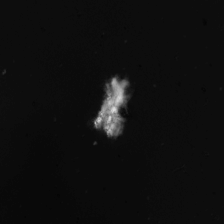

In [75]:
to_img = T.ToPILImage()
to_img(dataset_AB42_SYN[1][0])

## Add dropout

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.95)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_2 = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=100)

Epoch 099
----------
Train Loss:  0.6967 Acc:  0.4921
Epoch 199
----------
Train Loss:  0.6952 Acc:  0.5278
Epoch 299
----------
Train Loss:  0.6934 Acc:  0.5397
Epoch 399
----------
Train Loss:  0.6483 Acc:  0.6389
Epoch 499
----------
Train Loss:  0.6827 Acc:  0.6310
Epoch 599
----------
Train Loss:  0.6703 Acc:  0.5595
Epoch 699
----------
Train Loss:  0.5323 Acc:  0.7738
Epoch 799
----------
Train Loss:  0.5595 Acc:  0.7183
Epoch 899
----------
Train Loss:  0.6028 Acc:  0.6786
Epoch 999
----------
Train Loss:  0.5306 Acc:  0.7738
Epoch 1099
----------
Train Loss:  0.5790 Acc:  0.7857
Epoch 1199
----------
Train Loss:  0.4338 Acc:  0.7976
Epoch 1299
----------
Train Loss:  0.4542 Acc:  0.8175
Epoch 1399
----------
Train Loss:  0.5546 Acc:  0.6905
Epoch 1499
----------
Train Loss:  0.3911 Acc:  0.8532
Epoch 1599
----------
Train Loss:  0.4438 Acc:  0.8413
Epoch 1699
----------
Train Loss:  0.3249 Acc:  0.8810
Epoch 1799
----------
Train Loss:  0.3430 Acc:  0.8690
Epoch 1899
---------

In [30]:
_,acc_train_2 = test(resnet101_AB42_SYN_2, train_loader)
acc_train_2

tensor(1., device='cuda:0', dtype=torch.float64)

In [31]:
_,acc_test_2 = test(resnet101_AB42_SYN_2)
acc_test_2

tensor(0.8519, device='cuda:0', dtype=torch.float64)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_3 = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=80)

Epoch 079
----------
Train Loss:  0.6926 Acc:  0.5397
Epoch 179
----------
Train Loss:  0.6837 Acc:  0.5476
Epoch 279
----------
Train Loss:  0.6140 Acc:  0.6944
Epoch 379
----------
Train Loss:  0.6402 Acc:  0.6508
Epoch 479
----------
Train Loss:  0.4675 Acc:  0.7937
Epoch 579
----------
Train Loss:  0.4903 Acc:  0.7659
Epoch 679
----------
Train Loss:  0.3709 Acc:  0.8452
Epoch 779
----------
Train Loss:  0.5048 Acc:  0.7937
Epoch 879
----------
Train Loss:  0.6239 Acc:  0.6627
Epoch 979
----------
Train Loss:  0.5476 Acc:  0.7857
Epoch 1079
----------
Train Loss:  0.4391 Acc:  0.8016
Epoch 1179
----------
Train Loss:  0.2588 Acc:  0.9206
Epoch 1279
----------
Train Loss:  0.3295 Acc:  0.8770
Epoch 1379
----------
Train Loss:  0.4481 Acc:  0.8056
Epoch 1479
----------
Train Loss:  0.2932 Acc:  0.8968
Epoch 1579
----------
Train Loss:  0.2796 Acc:  0.8968
Epoch 1679
----------
Train Loss:  0.2199 Acc:  0.9167
Epoch 1779
----------
Train Loss:  0.2204 Acc:  0.9325
Epoch 1879
---------

In [34]:
_,acc_train_3 = test(resnet101_AB42_SYN_3, train_loader)
acc_train_3

tensor(1., device='cuda:0', dtype=torch.float64)

In [36]:
_,acc_test_3 = test(resnet101_AB42_SYN_3)
acc_test_3

tensor(0.8519, device='cuda:0', dtype=torch.float64)

## Using visdom  

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_4 = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=80)

Epoch 079
----------
Train Loss:  0.6959 Acc:  0.5040
Epoch 179
----------
Train Loss:  0.6897 Acc:  0.5317
Epoch 279
----------
Train Loss:  0.6504 Acc:  0.6548
Epoch 379
----------
Train Loss:  0.5244 Acc:  0.7698
Epoch 479
----------
Train Loss:  0.6599 Acc:  0.6111
Epoch 579
----------
Train Loss:  0.4396 Acc:  0.8095
Epoch 679
----------
Train Loss:  0.5395 Acc:  0.7619
Epoch 779
----------
Train Loss:  0.2955 Acc:  0.9167
Epoch 879
----------
Train Loss:  0.5041 Acc:  0.7579
Epoch 979
----------
Train Loss:  0.3571 Acc:  0.8849
Epoch 1079
----------
Train Loss:  0.3939 Acc:  0.8611
Epoch 1179
----------
Train Loss:  0.3651 Acc:  0.8651
Epoch 1279
----------
Train Loss:  0.1832 Acc:  0.9524
Epoch 1379
----------
Train Loss:  0.5124 Acc:  0.7857
Epoch 1479
----------
Train Loss:  0.2121 Acc:  0.9405
Epoch 1579
----------
Train Loss:  0.3827 Acc:  0.8611
Epoch 1679
----------
Train Loss:  0.1627 Acc:  0.9524
Epoch 1779
----------
Train Loss:  0.1013 Acc:  0.9802
Epoch 1879
---------

In [8]:
_,acc_test_4 = test(resnet101_AB42_SYN_4)
acc_test_4

tensor(0.8889, device='cuda:0', dtype=torch.float64)

# Visualize the Conv 

In [84]:
from PIL import Image

In [184]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image succesfully loaded")
    return image

def normalize(image):
    transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])
])
    image = transform(image)
    image = image.cuda()
    image = image.unsqueeze(0)
    return image

def predict(image):
    output = resnet101_AB42_SYN_3(image)
    _,pred = torch.max(output,1)
    return str(pred.item()), "AB-42" if pred.item() == 1 else "Alpha-syn"

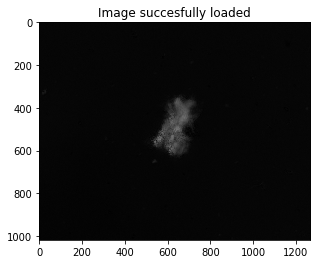

In [87]:
protein_1 = load_image("./data/images_AB42_SYN/(AB-42)(S1)(Region 002)(RS1)(PS1)(Retardance Lin).png")

In [88]:
resnet101_AB42_SYN_3

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

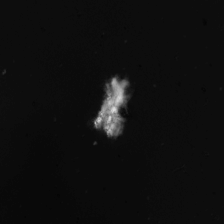

In [94]:
protein_2 = normalize(protein_1)

to_img(protein_2)

In [149]:
protein_2.shape

torch.Size([3, 224, 224])

In [150]:
protein_2.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [151]:
protein_2.unsqueeze(1).shape

torch.Size([3, 1, 224, 224])

In [154]:
p2 = protein_2.unsqueeze(0)
p2.squeeze().shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


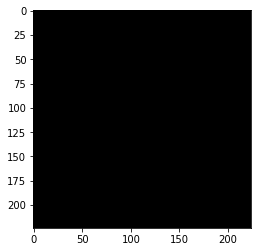

In [170]:
p2_test = protein_2.transpose(0,1)
p2_test = p2_test.transpose(1,2)

plt.imshow(p2_test.cpu())

In [171]:
p2_test = p2_test*torch.Tensor([0.5,0.5,0.5]).cuda() + torch.Tensor([0.5,0.5,0.5]).cuda()

In [ ]:
true_image = true_image * torch.Tensor([.5,.5,.5]).cuda() + torch.Tensor([.5,.5,.5]).cuda()

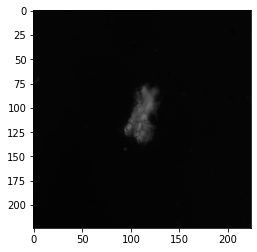

In [174]:
plt.imshow(p2_test.cpu())

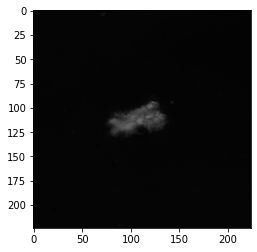

In [176]:
p2_test2 = protein_2.transpose(0,2)
p2_test2 = p2_test2*torch.Tensor([.5,.5,.5]).cuda() + torch.Tensor([.5,.5,.5]).cuda()
imgplot = plt.imshow(p2_test2.cpu())

In [122]:
protein_2 = protein_2.cuda()
predict(protein_2)

('1', 'AB-42')

## CNN heatmaps: Occlusion

In [228]:
def make_heatmap(model, image, true_class, k=8, stride=8):
    """
    Input image is of size(1,c,w,h)
    true class is a number corresponding to Imagenet classes
    k in the filter size(c,k,k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride) + 1), int(((image.shape[3]-k)/stride)+1))
    image = image.data
    
    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k,i:i+k] = 0
            temp_image = image.cuda()*h_filter.cuda()
            temp_softmax = model(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax,dim=1).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        i += stride
        a += 1
        
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un_Normalize image
    true_image = true_image * torch.Tensor([.5,.5,.5]).cuda() + torch.Tensor([.5,.5,.5]).cuda() 
    
    # plot both images
    fig = plt.figure()
    plt.rcParams['figure.figsize']=(10,10)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    
    # Normalize the hearmap
    heatmap = np.uint8(255*heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    
    return true_image, heatmap

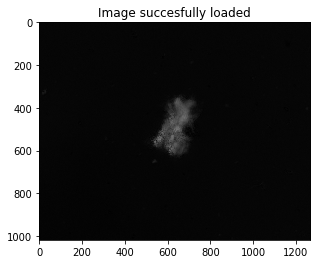

In [195]:
protein_2 = load_image("./data/images_AB42_SYN/(AB-42)(S1)(Region 002)(RS1)(PS1)(Retardance Lin).png")

In [196]:
protein_2 = normalize(protein_2)

In [197]:
predict(protein_2)

('1', 'AB-42')

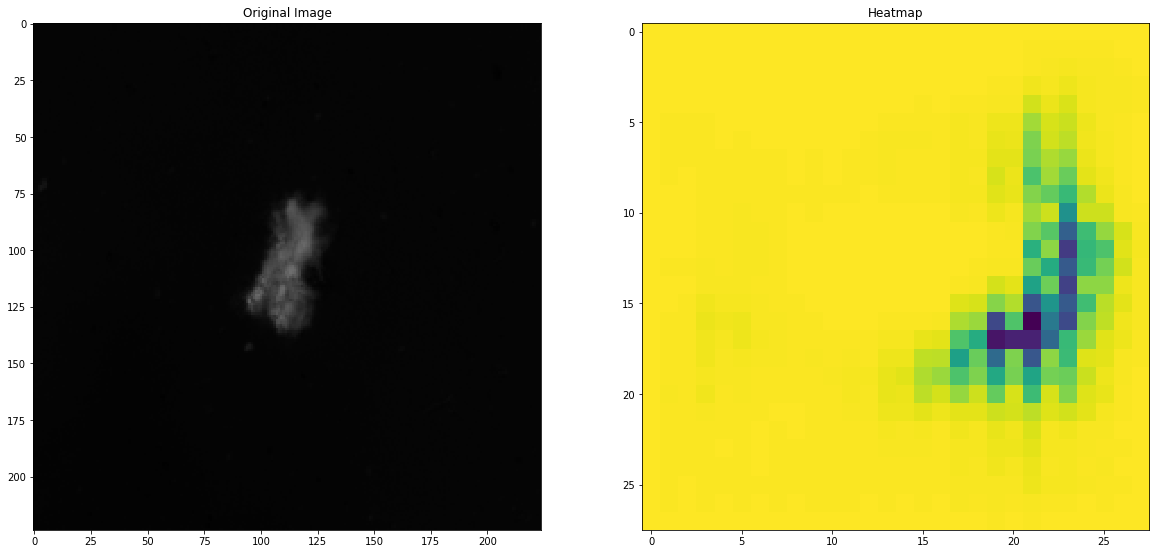

In [201]:
true_image, protein_heatmap = make_heatmap(resnet101_AB42_SYN_3, protein_2, 1)

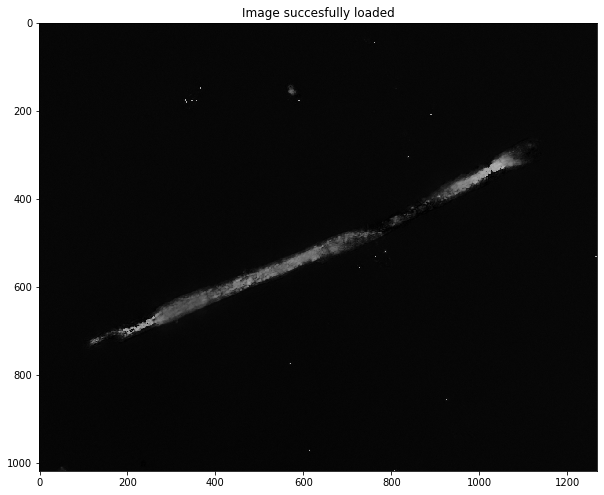

In [205]:
plt.rcParams['figure.figsize']=(10,10)
protein_4 = load_image("./data/images_AB42_SYN/(AB-42)(S1)(Region 004)(RS1)(PS1)(Retardance Lin).png")

In [207]:
protein_4 = normalize(protein_4)

In [208]:
predict(protein_4)

('1', 'AB-42')

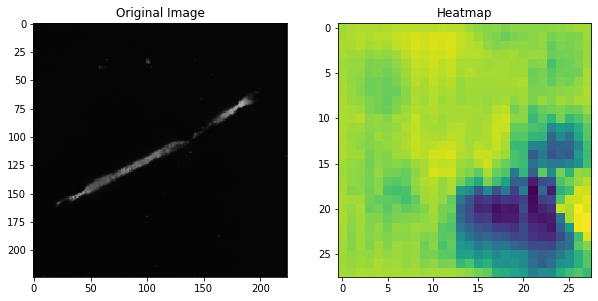

In [209]:
true_image_4, protein_heatmap_4 = make_heatmap(resnet101_AB42_SYN_3, protein_4, 1)

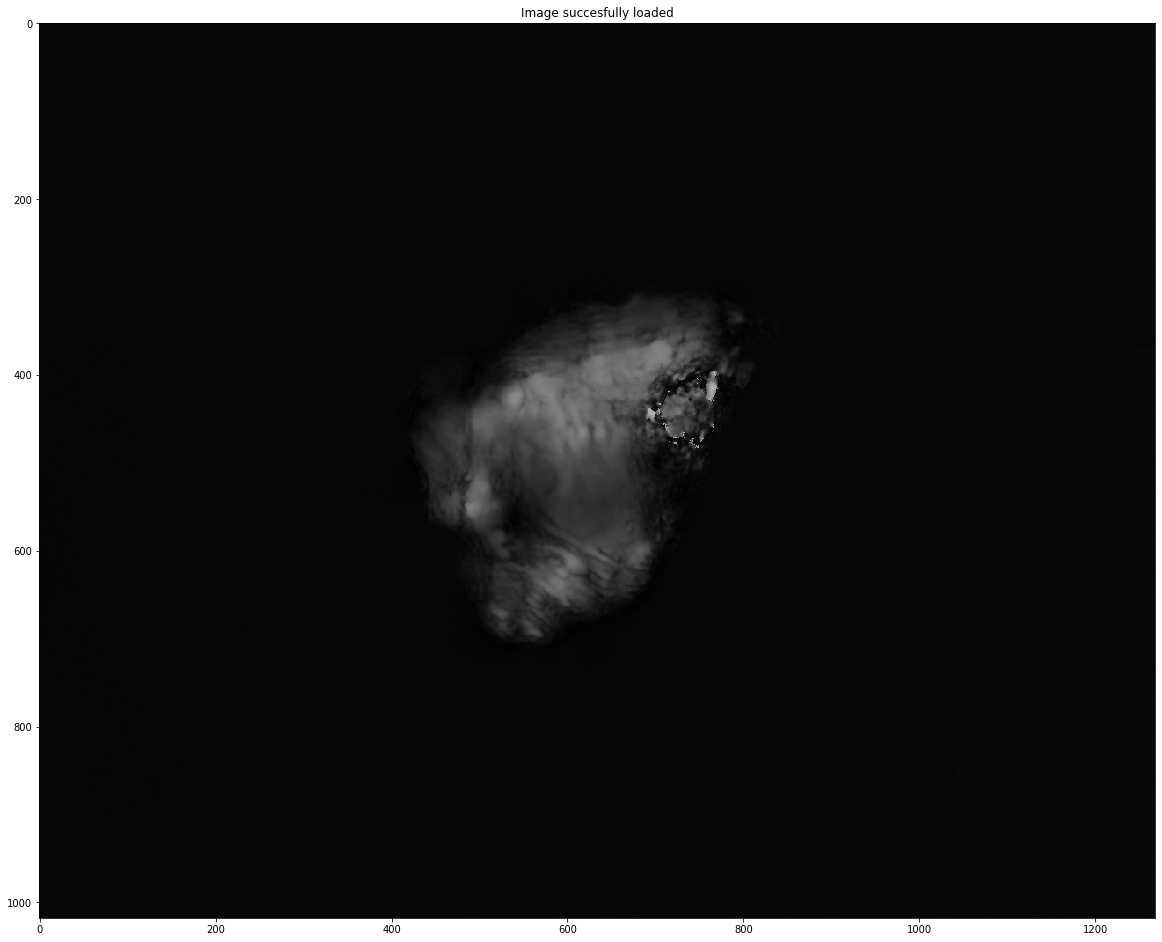

In [210]:
protein_20 = load_image("./data/images_AB42_SYN/(AB-42)(S1)(Region 018)(RS1)(PS1)(Retardance Lin).png")

In [211]:
protein_20 = normalize(protein_20)
predict(protein_20)

('1', 'AB-42')

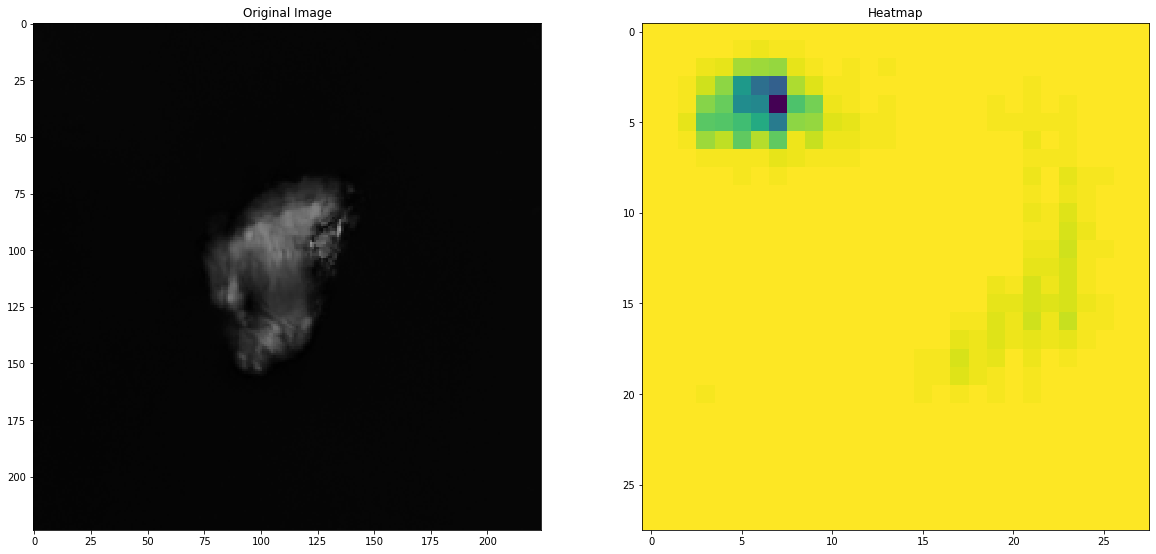

In [212]:
true_image_20, protein_heatmap_20 = make_heatmap(resnet101_AB42_SYN_3, protein_20, 1)

In [248]:
protein_heatmap_20

array([[254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254],
       [254, 254, 254, 254, 253, 254, 253, 253, 253, 253, 252, 252, 249,
        252, 251, 253, 251, 253, 253, 253, 252, 254, 253, 254, 253, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254],
       [254, 254, 254, 254, 253, 254, 254, 253, 252, 253, 254, 252, 247,
        252, 253, 253, 251, 253, 254, 253, 252, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254],
       [254, 254, 254, 253, 253, 253,

array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254]], dtype=uint8)

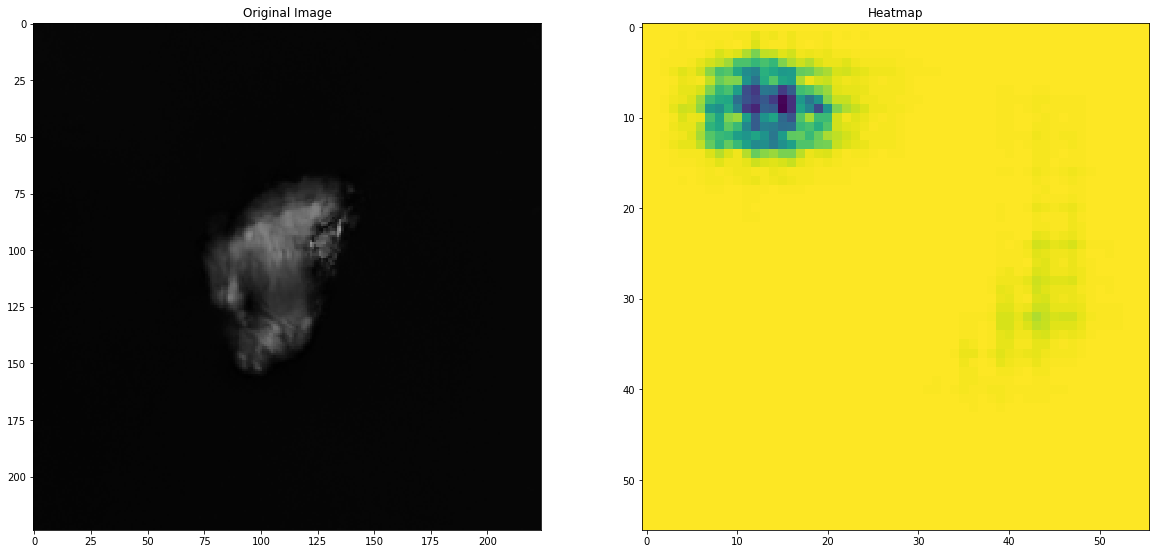

In [241]:
true_image_20, protein_heatmap_20 = make_heatmap(resnet101_AB42_SYN_3, protein_20, 1,k=4, stride=4)

In [243]:
protein_heatmap_20 

array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254]], dtype=uint8)

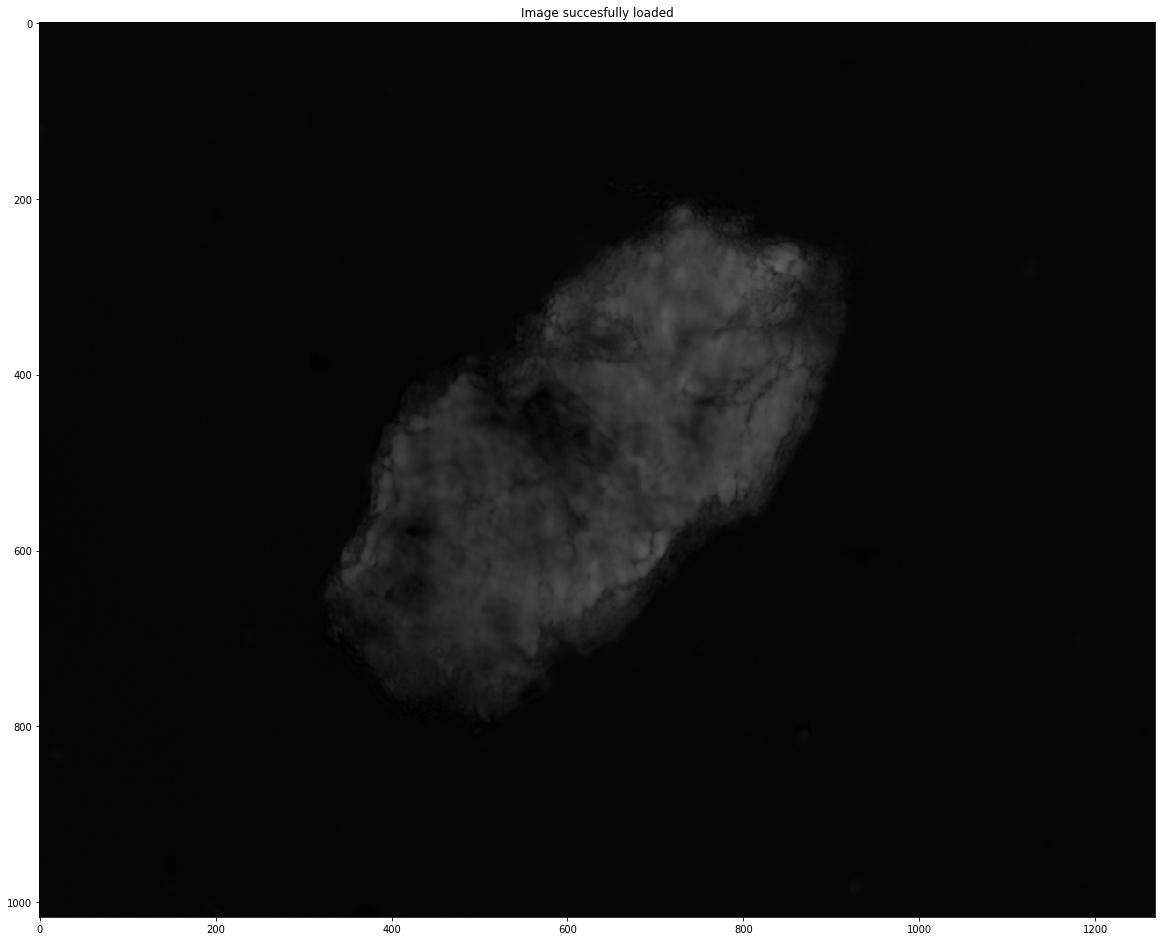

In [214]:
protein_36= load_image("./data/images_AB42_SYN/(AB-42)(S1)(Region 030)(RS1)(PS1)(Retardance Lin).png")

In [215]:
protein_36 = normalize(protein_36)
predict(protein_36)

('1', 'AB-42')

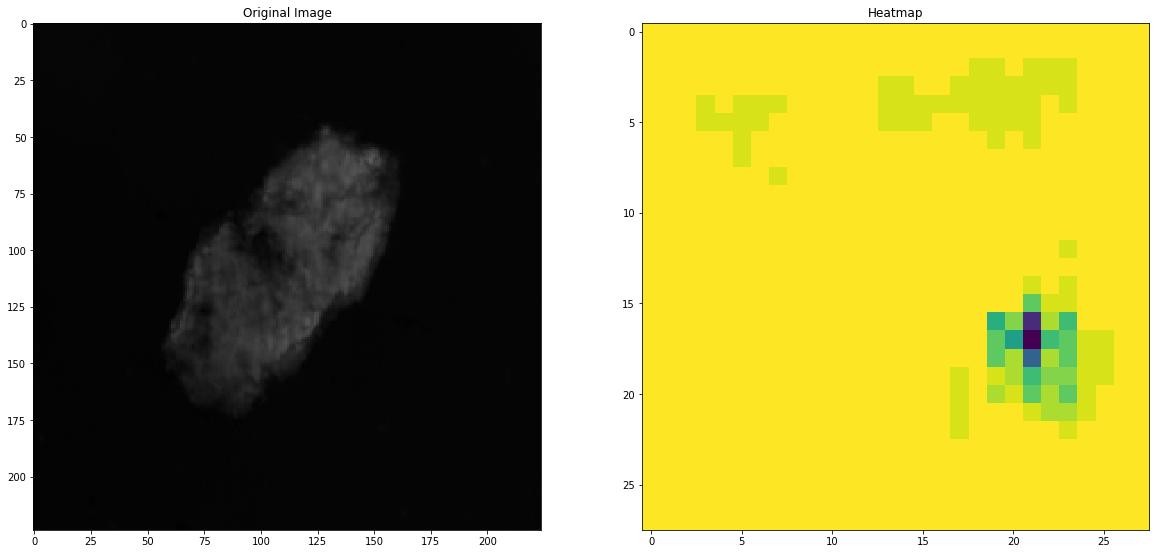

In [216]:
true_image_36, protein_heatmap_36 = make_heatmap(resnet101_AB42_SYN_3, protein_36, 1)

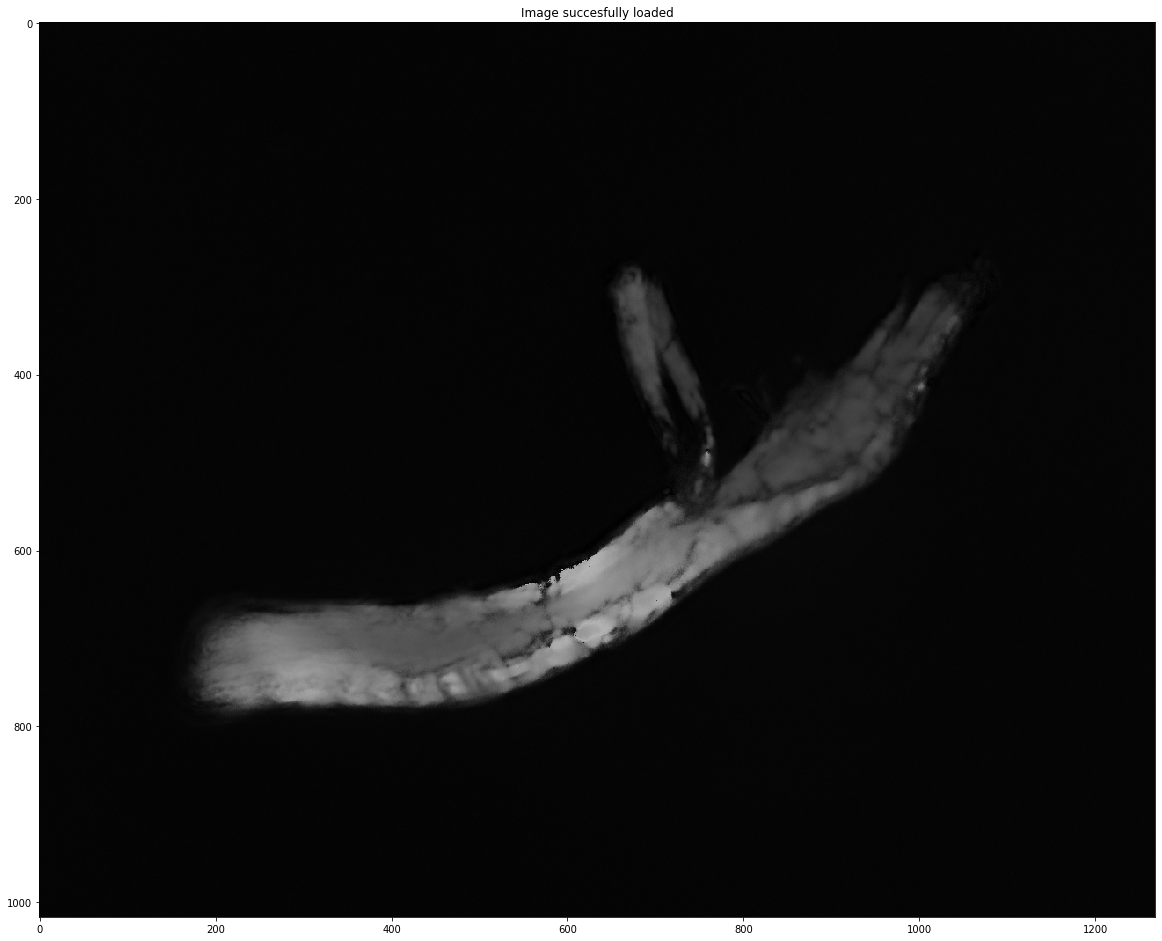

In [217]:
protein_a1= load_image("./data/images_AB42_SYN/(Alpha-syn)(U1)(633 Region 011)(RS1)(PS1)(Retardance Lin).png")

In [218]:
protein_a1 = normalize(protein_a1)
predict(protein_a1)

('0', 'Alpha-syn')

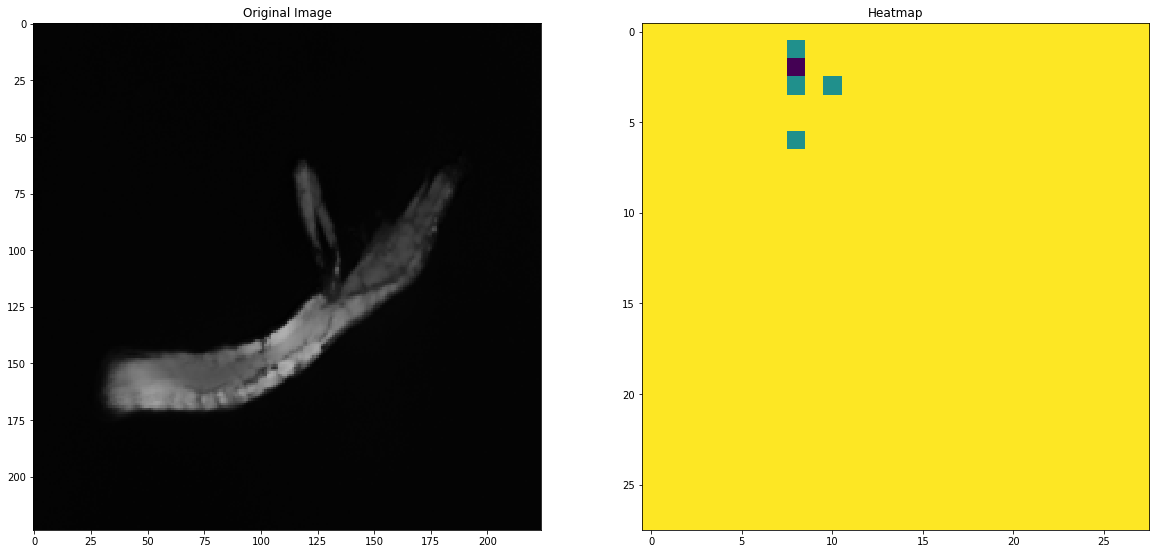

In [221]:
true_image_a1, protein_heatmap_a1 = make_heatmap(resnet101_AB42_SYN_3, protein_a1, 0)

In [240]:
protein_heatmap_a1

array([[254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 253, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 252, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 253, 254, 253, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [25

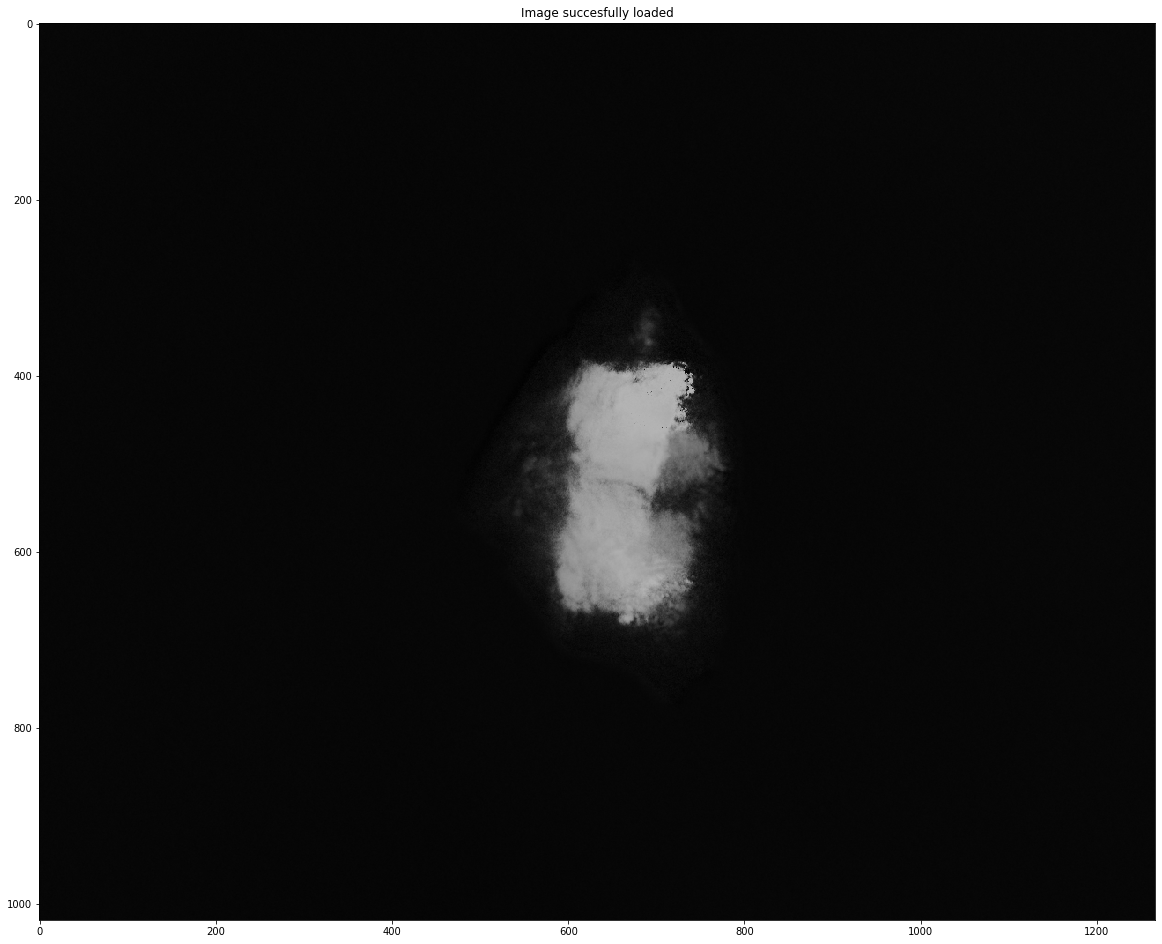

In [225]:
protein_a2= load_image("./data/images_AB42_SYN/(Alpha-syn)(S2)(633 Region 005)(RS1)(PS1)(Retardance Lin).png")

In [226]:
protein_a2 = normalize(protein_a2)
predict(protein_a2)

('0', 'Alpha-syn')

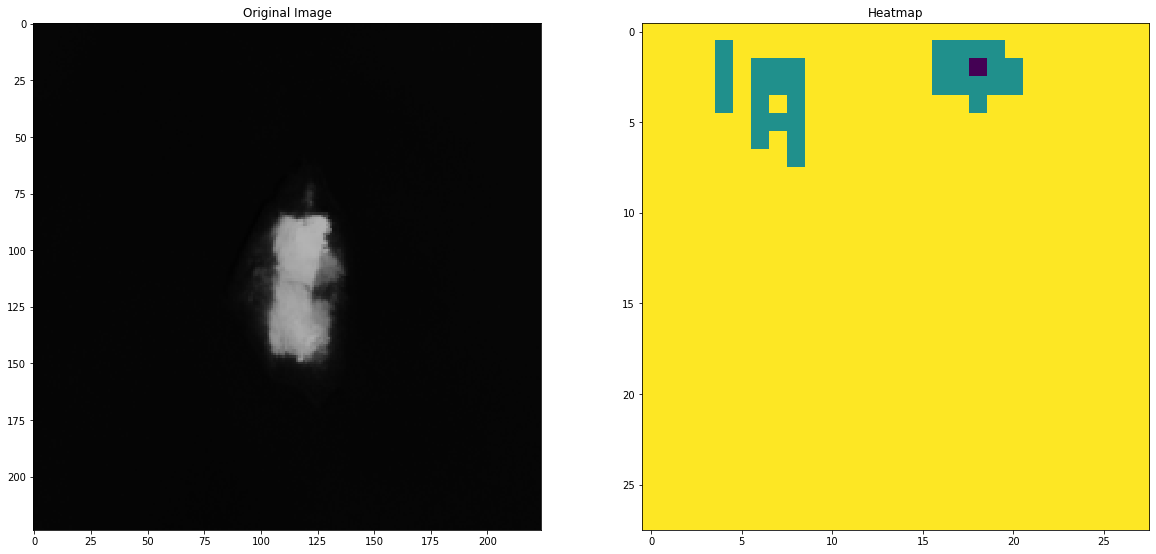

In [227]:
true_image_a2, protein_heatmap_a2 = make_heatmap(resnet101_AB42_SYN_3, protein_a2, 0)

In [239]:
protein_heatmap_a2

array([[254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 253, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 253, 254, 253, 253, 253, 254, 254, 254, 254,
        254, 254, 254, 253, 253, 252, 253, 253, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 253, 254, 253, 253, 253, 254, 254, 254, 254,
        254, 254, 254, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 253, 254, 253, 254, 253, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 253, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 253, 253, 253, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [25

## Another occlusion map 

In [252]:
def occlusion(model, image, label, occ_size=8, occ_stride=8, occ_pixel = 0.5):
    
    # width and height of the image
    width, height = image.shape[-2], image.shape[-1]
    
    # setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
    
    # create a white image of sizes we defined
    heatmap = torch.zeros((output_height,output_width))
    
    # iterate all the pixels in each column
    for h in range(0,height):
        for w in range(0,width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height,h_start+occ_size)
            w_end = min(width, w_start+occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
                
            input_image = image.clone().detach()
            
            # replacing all the pixel information in the image with occ_pixel(grey) 
            # in the specified location
            input_image[:,:,w_start:w_end,h_start:h_end] = occ_pixel
            
            # run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output,dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h,w] = prob
            
        return heatmap

In [253]:
heatmap = occlusion(resnet101_AB42_SYN_3, protein_20,1)

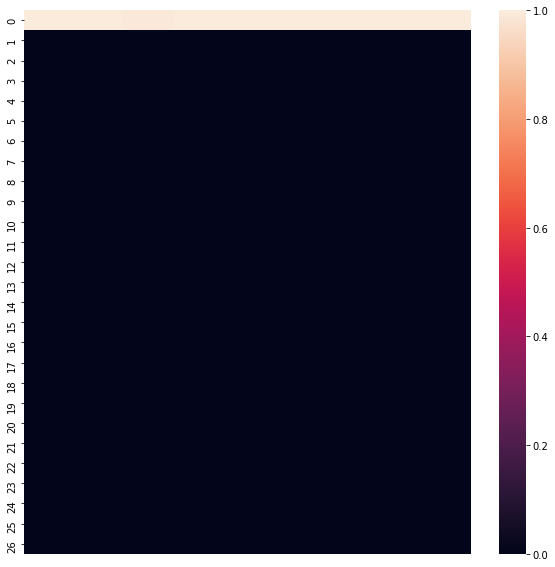

In [254]:
import seaborn as sns

# displaying the image using seaborn heatmap
# Also setting the maximum value of gradient to probability
imgplot = sns.heatmap(heatmap,xticklabels=False, vmax=1)
figure = imgplot.get_figure()